# Initial Exploratory Taxi Trip DataSet
The objective of this notebook is to carry out an initial analysis of the taxi trips in Chicago and then on the basis of this analysis carry out a filtering of the erroneous trips.

## Chicago Coordinates 
-87.6244212, 41.8755616

## 1 Create our environment

### 1.1 Create the Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext

In [3]:
sc_conf = SparkConf()

In [4]:
sc_conf.set('spark.driver.port', '62678')
sc_conf.set('spark.rdd.compress', 'True')
sc_conf.set('spark.driver.host', '127.0.0.1')
sc_conf.set('spark.serializer.objectStreamReset', '100')
sc_conf.set('spark.master', 'local[*]')
sc_conf.set('spark.executor.id', 'driver')
sc_conf.set('spark.submit.deployMode', 'client')
sc_conf.set('spark.ui.showConsoleProgress', 'true')
sc_conf.set('spark.app.name', 'pyspark-shell')
sc_conf.set("spark.executor.memory","1g")
sc_conf.set("spark.driver.memory","6g")

In [5]:
sc_conf.getAll()

dict_items([('spark.driver.port', '62678'), ('spark.rdd.compress', 'True'), ('spark.driver.host', '127.0.0.1'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell'), ('spark.executor.memory', '1g'), ('spark.driver.memory', '6g')])

In [6]:
sc = SparkContext(conf=sc_conf)

In [7]:
sql = SQLContext(sc)

In [8]:
session = sql.sparkSession
session

In [9]:
session.sparkContext.getConf().getAll()

[('spark.driver.port', '62678'),
 ('spark.driver.host', '127.0.0.1'),
 ('spark.driver.memory', '6g'),
 ('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1555677531332'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

## 2 Load the libraries

In [10]:
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import webbrowser
import seaborn as sns
from tqdm import tqdm_notebook
pd.options.display.max_columns = None

## 3 Read the data

In [11]:
taxi_df = session.read.csv('../Data/Taxi_Trips.csv.gz',
                              header=True,
                              inferSchema=True)
taxi_df.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+--------------------------+---------------+
|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tips|Tolls|Extras|Trip Total|Payment Type|             Company|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid  Location|Community Areas|
+--------------------+--------------------+--------------------+--------------------+------------+----------+-------------------

## 4 Initial Data analysis 

### 4.1 Get some trips to check the data

In [12]:
taxi_obs=taxi_df.limit(5)
taxi_obs.toPandas()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,2014a7f89716c3cccc7d7935a3dfd16d8908f33c,9492b268e840fcd19b554ae0d61ab86a48eee56b7fba98...,09/22/2015 05:30:00 PM,09/22/2015 05:45:00 PM,420,1.1,1.703184e+10,1.703108e+10,32,8,6.25,0.0,0.0,0.0,6.25,Cash,None,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),38
1,2014a81cdb5b71886837612c5e53d59c72f11b2d,d552bd52346c36f10ea828d1f770cf358278f7beecf08a...,09/17/2013 06:45:00 PM,09/17/2013 07:00:00 PM,540,3.2,NaN,NaN,8,24,9.65,0.0,0.0,0.0,9.65,Cash,None,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),37
2,2014a8218f8d69bb62b838f31f3f59bf98ff9478,1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...,01/02/2016 10:30:00 PM,01/02/2016 10:30:00 PM,180,0.8,1.703108e+10,1.703108e+10,8,8,5.25,0.0,0.0,0.0,5.25,Cash,None,41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),37
3,2014a86b8e1e98a8647e0dc815cac0537ab5c40e,d96279b9f0d9e121dca78282e8ead29d8a7aa18dc89d78...,12/15/2015 11:45:00 AM,12/15/2015 11:45:00 AM,360,0.0,NaN,NaN,7,7,6.05,0.0,0.0,0.0,6.05,Cash,Taxi Affiliation Services,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),68
4,2014a8724a96df31e968f45925101c31d2e6ea31,a485350f36958a2783d154ee7562f7809254058189b91d...,06/03/2013 07:00:00 AM,06/03/2013 07:15:00 AM,480,0.9,1.703184e+10,1.703132e+10,32,32,6.45,0.0,0.0,0.0,6.45,Cash,None,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),38


The following columns can be deleted because they do not add value as a result of which they are unions or repetitions of other columns:

    - Pickup Census Tract	
    - Dropoff Census Tract
    - Pickup Centroid Location
    - Dropoff Centroid Location
    - Community Areas


### 4.2 Study the dimensions of the dataset

In [13]:
taxi_df.count()

112860054

In [14]:
len(taxi_df.columns)

24

### 4.3 Check the names and types of the variables

In [15]:
taxi_df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

## 5 Data Wrangling

### 4.4 Change the name of the variables to comply with good practices

In [16]:
for col in taxi_df.columns:
    new_col=col.lower().replace(" ","_")
    taxi_df = taxi_df.withColumnRenamed(col,new_col)
taxi_df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- pickup_centroid_location: string (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_centroid_

### 4.5 Delete fields that do not add value

In [17]:
#The following columns can be deleted because they do not add value as a result of which they are unions or 
#repetitions of other columns
taxi_df = taxi_df.drop('pickup_census_tract',
                       'dropoff_census_tract',
                       'pickup_centroid_location',
                       'dropoff_centroid__location',
                       'community_areas')

In [18]:
taxi_df.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_centroid_longitude: double (nullable = true)



### 4.6 Manage the dates

#### 4.6.1 Convert the dates from string format to date format

In [19]:
# Check the start trip and the end trip before change the format
taxi_df.select(['trip_start_timestamp', 'trip_end_timestamp']).show(truncate=False)

+----------------------+----------------------+
|trip_start_timestamp  |trip_end_timestamp    |
+----------------------+----------------------+
|09/22/2015 05:30:00 PM|09/22/2015 05:45:00 PM|
|09/17/2013 06:45:00 PM|09/17/2013 07:00:00 PM|
|01/02/2016 10:30:00 PM|01/02/2016 10:30:00 PM|
|12/15/2015 11:45:00 AM|12/15/2015 11:45:00 AM|
|06/03/2013 07:00:00 AM|06/03/2013 07:15:00 AM|
|07/08/2015 11:30:00 AM|07/08/2015 11:30:00 AM|
|12/05/2016 03:30:00 PM|12/05/2016 03:30:00 PM|
|11/30/2015 05:00:00 PM|11/30/2015 05:00:00 PM|
|11/19/2016 03:45:00 AM|11/19/2016 04:00:00 AM|
|04/18/2014 11:30:00 PM|04/18/2014 11:45:00 PM|
|09/13/2013 05:45:00 PM|09/13/2013 06:00:00 PM|
|05/30/2014 06:15:00 PM|05/30/2014 06:30:00 PM|
|12/09/2016 02:00:00 PM|12/09/2016 02:00:00 PM|
|04/13/2015 04:45:00 PM|04/13/2015 05:00:00 PM|
|07/16/2013 06:30:00 PM|07/16/2013 06:45:00 PM|
|11/28/2013 04:45:00 AM|11/28/2013 04:45:00 AM|
|03/06/2014 08:30:00 AM|03/06/2014 08:30:00 AM|
|05/14/2016 10:30:00 AM|05/14/2016 10:45

In [20]:
#Convert to date format ()
taxi_df = taxi_df.withColumn("trip_start_timestamp",
                             F.from_unixtime(F.unix_timestamp(F.col("trip_start_timestamp"),
                                                           format="MM/dd/yyyy hh:mm:ss aa")))
taxi_df = taxi_df.withColumn("trip_end_timestamp",
                             F.from_unixtime(F.unix_timestamp(F.col("trip_end_timestamp"),
                                                           format="MM/dd/yyyy hh:mm:ss aa")))

In [21]:
#Check the result
taxi_df.select(['trip_start_timestamp', 'trip_end_timestamp']).show(truncate=False)

+--------------------+-------------------+
|trip_start_timestamp|trip_end_timestamp |
+--------------------+-------------------+
|2015-09-22 17:30:00 |2015-09-22 17:45:00|
|2013-09-17 18:45:00 |2013-09-17 19:00:00|
|2016-01-02 22:30:00 |2016-01-02 22:30:00|
|2015-12-15 11:45:00 |2015-12-15 11:45:00|
|2013-06-03 07:00:00 |2013-06-03 07:15:00|
|2015-07-08 11:30:00 |2015-07-08 11:30:00|
|2016-12-05 15:30:00 |2016-12-05 15:30:00|
|2015-11-30 17:00:00 |2015-11-30 17:00:00|
|2016-11-19 03:45:00 |2016-11-19 04:00:00|
|2014-04-18 23:30:00 |2014-04-18 23:45:00|
|2013-09-13 17:45:00 |2013-09-13 18:00:00|
|2014-05-30 18:15:00 |2014-05-30 18:30:00|
|2016-12-09 14:00:00 |2016-12-09 14:00:00|
|2015-04-13 16:45:00 |2015-04-13 17:00:00|
|2013-07-16 18:30:00 |2013-07-16 18:45:00|
|2013-11-28 04:45:00 |2013-11-28 04:45:00|
|2014-03-06 08:30:00 |2014-03-06 08:30:00|
|2016-05-14 10:30:00 |2016-05-14 10:45:00|
|2017-03-27 14:00:00 |2017-03-27 14:00:00|
|2014-04-27 11:15:00 |2014-04-27 11:15:00|
+----------

#### 4.6.2 Check the extreme values of the dates

In [22]:
taxi_df.select(F.max('trip_start_timestamp'),F.min('trip_start_timestamp')).show()

+-------------------------+-------------------------+
|max(trip_start_timestamp)|min(trip_start_timestamp)|
+-------------------------+-------------------------+
|      2017-08-01 00:00:00|      2013-01-01 00:00:00|
+-------------------------+-------------------------+



In [23]:
taxi_df.select(F.max('trip_end_timestamp'),F.min('trip_end_timestamp')).show()

+-----------------------+-----------------------+
|max(trip_end_timestamp)|min(trip_end_timestamp)|
+-----------------------+-----------------------+
|    2017-08-01 15:30:00|    1900-01-01 00:00:00|
+-----------------------+-----------------------+



### 4.7 Check duplicates

In [24]:
taxi_df.dropDuplicates(['trip_id', 'taxi_id']).count()

112860054

There is not duplicates

### 4.8 Study if there are variables that always or practically always have the same value

Separate the dataframe in two to realize our analysis:
    
    - One dataframe with numeric columns
    - One dataframe with categorical columns

In [25]:
n_rows = taxi_df.count()
numeric_vars = []
categoric_vars = []

for col, tipo in taxi_df.dtypes:
    if tipo!="string":
        numeric_vars.append(col)
    else:
        categoric_vars.append(col)     

In [26]:
# We delete trip_id from our analysis because it is the only value that allows us to identify travel and we know it´s
# an unique value (it has not duplicates)
categoric_vars.remove('trip_id')

#### 4.8.1 Categoric columns

In [27]:
for col in categoric_vars:
    print(col)
    taxi_df.groupby(col).count().sort(F.col("count").desc()).withColumn("frecuencia(%)",
                  F.round((100*F.col("count")/n_rows),2)).show()

taxi_id
+--------------------+-----+-------------+
|             taxi_id|count|frecuencia(%)|
+--------------------+-----+-------------+
|aebf720288b80a8ee...|59800|         0.05|
|f68eb3233f3e33e98...|53713|         0.05|
|d3a5f1452b4a1db2a...|53237|         0.05|
|774c16d2c0c72290e...|52971|         0.05|
|9eb860ce5cb7ff8e3...|52835|         0.05|
|a21e9e59e7c6a55f3...|52322|         0.05|
|01910e6c9e129a9a7...|52055|         0.05|
|ffc2a618ad19a63fa...|52044|         0.05|
|53f28dea0e1172c28...|51701|         0.05|
|9d69a11bc339eab6a...|51446|         0.05|
|5ba3a19b228cd79e8...|51131|         0.05|
|0861cb74337c620cb...|51055|         0.05|
|b2a007b1410c7208a...|50975|         0.05|
|1158f25979ad78fd3...|50913|         0.05|
|74b9b3ba2f90ab6df...|50442|         0.04|
|89bfd3f9c1a6014be...|49765|         0.04|
|842e2b1cd011fab01...|49633|         0.04|
|4f189764b8d9b6f71...|49422|         0.04|
|7bdac954f2be7f55a...|49337|         0.04|
|4f1e94982e6851725...|49144|         0.04|
+--

We have observed that in the column 'payment_type' there is the value 'Unknown', so we are going to convert it to null

In [28]:
taxi_df = taxi_df.withColumn('payment_type',
                            F.when(F.col('payment_type')=='Unknown',None).otherwise(F.col('payment_type')))

In [29]:
#Check that 'Unknown' value has been converted to null
print('payment_type')
taxi_df.groupby('payment_type').count().sort(F.col("count").desc()).withColumn("frecuencia(%)",
                                                                    F.round((100*F.col("count")/n_rows),2)).show()

payment_type
+------------+--------+-------------+
|payment_type|   count|frecuencia(%)|
+------------+--------+-------------+
|        Cash|67703399|        59.99|
| Credit Card|44087311|        39.06|
|   No Charge|  720341|         0.64|
|        null|  243626|         0.22|
|     Dispute|   61094|         0.05|
|       Pcard|   29700|         0.03|
|      Prcard|   14164|         0.01|
|      Mobile|     396|          0.0|
|    Way2ride|      23|          0.0|
+------------+--------+-------------+



#### 4.8.2 Numeric columns

In [30]:
for col in numeric_vars:
    print(col)
    taxi_df.groupby(col).count().sort(F.col("count").desc()).withColumn("frecuencia(%)",
                  F.round((100*F.col("count")/n_rows),2)).show()

trip_seconds
+------------+-------+-------------+
|trip_seconds|  count|frecuencia(%)|
+------------+-------+-------------+
|           0|9223119|         8.17|
|         360|7656937|         6.78|
|         420|7563126|          6.7|
|         300|7203627|         6.38|
|         480|7096002|         6.29|
|         540|6464109|         5.73|
|         240|6048981|         5.36|
|         600|5766878|         5.11|
|         660|5081404|          4.5|
|         720|4432931|         3.93|
|         180|4178873|          3.7|
|         780|3829466|         3.39|
|         840|3283975|         2.91|
|         900|2802779|         2.48|
|         960|2385938|         2.11|
|         120|2165776|         1.92|
|        1020|2040405|         1.81|
|        1080|1761459|         1.56|
|        1140|1555697|         1.38|
|          60|1416459|         1.26|
+------------+-------+-------------+
only showing top 20 rows

trip_miles
+----------+--------+-------------+
|trip_miles|   count|frecu

+-------------------------+--------+-------------+
|pickup_centroid_longitude|   count|frecuencia(%)|
+-------------------------+--------+-------------+
|                     null|16780361|        14.87|
|            -87.632746489|10007490|         8.87|
|            -87.620992913| 5817480|         5.15|
|            -87.633308037| 4710264|         4.17|
|            -87.626214906| 4477579|         3.97|
|            -87.903039661| 4073139|         3.61|
|             -87.63186395| 4052324|         3.59|
|            -87.655998182| 3610053|          3.2|
|            -87.642648998| 3241766|         2.87|
|            -87.618868355| 2721247|         2.41|
|            -87.625192142| 2523588|         2.24|
|             -87.63784421| 2495453|         2.21|
|            -87.626210532| 2377074|         2.11|
|            -87.649488729| 2174934|         1.93|
|            -87.628874157| 1954904|         1.73|
|            -87.642808466| 1937035|         1.72|
|            -87.676355989| 192

### 4.9 Study the null values 

### 4.9.1 Get the number of nulls

In [31]:
nulls = {}
for column in taxi_df.columns:
    n_nulls = taxi_df.filter(F.col(column).isNull()).count()
    perc_nulls = 100 * n_nulls / n_rows
    nulls[column]=[n_nulls,round(perc_nulls,2)]

nulls_df = pd.DataFrame(nulls).T
nulls_df.columns = ['nulls','% nulls']
nulls_df

NameError: name 'nulos' is not defined

In [32]:
nulls_df = pd.DataFrame(nulls).T
nulls_df.columns = ['nulls','% nulls']
nulls_df

,nulls,% nulls
trip_id,0.0,0.00
taxi_id,0.0,0.00
trip_start_timestamp,19849.0,0.02
trip_end_timestamp,36021.0,0.03
trip_seconds,1289707.0,1.14
trip_miles,633.0,0.00
pickup_community_area,16782342.0,14.87
dropoff_community_area,19095838.0,16.92
fare,1076.0,0.00
tips,1076.0,0.00


### 4.9.2 Plot the number of nulls

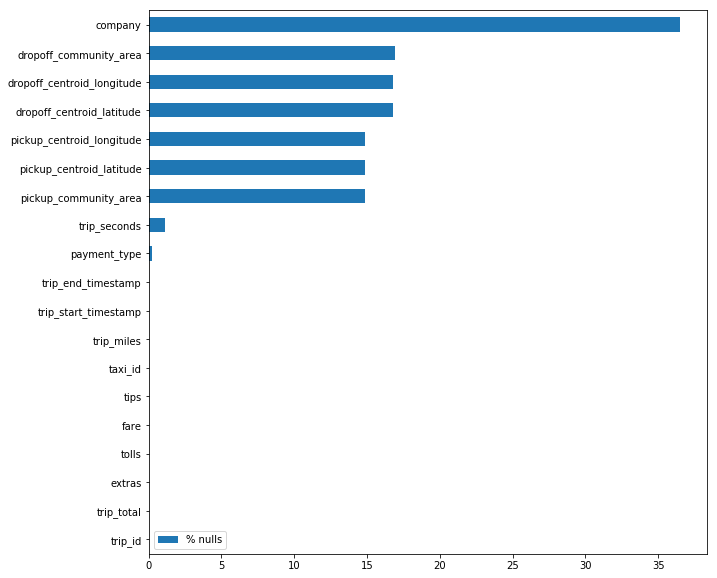

In [34]:
nulls_df.sort_values('% nulls').plot.barh(y='% nulls',figsize=(10,10))

### 4.10 Study outliers

In [35]:
for num_var in numeric_vars:
    print(num_var)
    describe = taxi_df.select(F.round(F.mean(num_var), 2).alias("mean"),
                                F.min(num_var).alias("min"),
                                F.max(num_var).alias("max"),
                                F.round(F.stddev(num_var), 2).alias("stddv"))
    q1, median, q3 = taxi_df.approxQuantile(num_var, [0.25, 0.5, 0.75], 0)
    describe = describe.withColumn("q1", F.lit(q1))
    describe = describe.withColumn("median", F.lit(median))
    describe = describe.withColumn("q3", F.lit(q3))
    describe = describe.withColumn("iqr", F.lit(q3-q1))
    describe.show()

trip_seconds


Py4JJavaError: An error occurred while calling o523.approxQuantile.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 93.0 failed 1 times, most recent failure: Lost task 0.0 in stage 93.0 (TID 4073, localhost, executor driver): ExecutorLostFailure (executor driver exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 3110931 ms
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.sql.execution.stat.StatFunctions$.multipleApproxQuantiles(StatFunctions.scala:102)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:100)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:115)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


## 5 Clean the dataset

### 5.1 Drop the trips with null values

In [ ]:
taxi_df = taxi_df.dropna(how='any',
                         subset=['trip_id',
                                  'taxi_id',
                                  'trip_start_timestamp',
                                  'trip_end_timestamp',
                                  'trip_seconds',
                                  'trip_miles',
                                  'pickup_community_area',
                                  'dropoff_community_area',
                                  'fare',
                                  'tips',
                                  'tolls',
                                  'extras',
                                  'trip_total',
                                  'payment_type',
                                  'company',
                                  'pickup_centroid_latitude',
                                  'pickup_centroid_longitude',
                                  'dropoff_centroid_latitude',
                                  'dropoff_centroid_longitude'])

In [ ]:
taxi_df.count()

### 5.2 Drop the trips with extrange values

In [ ]:
taxi_df = taxi_df.filter((F.col("trip_start_timestamp") <= (F.col("trip_end_timestamp"))) &
                (F.col("trip_seconds") > 0) &
                (F.col("trip_miles") > 0) &
                (F.col("fare") > 0) &
                (F.col("tips") >= 0) &
                (F.col("tolls") >= 0) &
                (F.col("extras") >= 0) &
                (F.col("trip_total") > 0))

In [ ]:
taxi_df.count()